In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [175]:

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_massfunc import CSMF, SHMR, scatter_stat, mass_rank
from jsm_datareduc import prep_data
from galhalo import lgMs_D22_dex, dex_sampler, lgMs_D22_det
import galhalo
import os

In [176]:
conv = 1/np.log10(np.exp(1))

stellar_mass = 7
Ndex = 100
Nsamp = 10000
dex = np.linspace(0,3,Ndex)
dist = np.zeros(shape=(Ndex, Nsamp))

for i, val in enumerate(dex):
    dist[i] = conv*np.log10(np.random.lognormal(mean=stellar_mass, sigma=val, size=Nsamp))

real_dist = np.zeros(shape=(Ndex, Nsamp))
for i, val in enumerate(dex):
    real_dist[i] = np.random.lognormal(mean=stellar_mass, sigma=val, size=Nsamp)

ave = np.mean(dist, axis=1)
std = np.std(dist, axis=1)

In [177]:
def avemass(mu, sigma):
    exp = mu + (sigma**2)/2
    return np.exp(exp) # the expectation value

In [178]:
def norm(expt_val, sigma):
    mu = np.log(expt_val) - (sigma**2)/2
    return mu

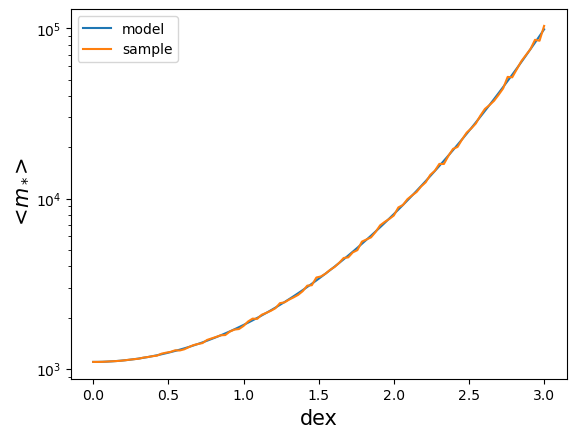

In [179]:
sigma = np.linspace(0,2,50)

plt.plot(dex, avemass(stellar_mass, dex), label="model")
plt.plot(dex, avemass(ave, dex), label="sample")
plt.xlabel("dex", fontsize=15)
plt.ylabel(" <$m_*$>", fontsize=15)
plt.legend()
plt.yscale("log")
plt.savefig("../figures/expectation_value.pdf")
plt.show()


----------

$\log_{10} (M_{*}) = \log_{10} (\epsilon M_{1})+ \alpha \log_{10} (M_{peak}) - \alpha \log_{10}(M_1)$

$ M_{*} = \epsilon M_{1} \left( \frac{M_{peak}}{M_1} \right)^{\alpha}$

$ M_{*} = \left( \epsilon M_{1}^{1-\alpha} \right) \left( M_{peak} \right)^{\alpha} $

$\log_{10} (M_{*}) = \alpha \log_{10} (M_{peak}) + \log_{10}\left( \epsilon M_{1}^{1-\alpha} \right)$

$y = mx + b$, where $a$ is the slope, and $b$ the intercept, is a function of the slope and the normalization 

In [180]:
Mh = prep_data(("../../data/12_4_0/acc_surv_mass.npy"), convert=False, includenan=False)
Ms = prep_data(("../../data/12_4_0/acc_surv_mass.npy"), includenan=False)

halo_mass = Mh[0]
stellar_mass = Ms[0]

### Testing to see if the two methods of sampling are equivalent

In [181]:
def test_conv(lgMs_arr, dex, N_samples):

    scatter = np.random.normal(loc=0, scale=dex, size=(N_samples, lgMs_arr.shape[0]))
    return lgMs_arr + scatter

In [182]:
def test_convlog(lgMs_arr, dex, N_samples):

    sample = np.random.lognormal(lgMs_arr, dex, size=(N_samples, lgMs_arr.shape[0]))
    return np.log10(sample)/np.log10(np.exp(1))

In [183]:
hmm = test_conv(stellar_mass, 1, 10000)
hmmlog = test_convlog(stellar_mass, 1, 10000)

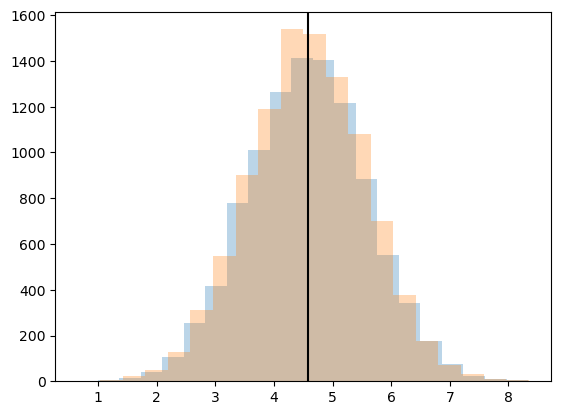

In [184]:
i= 23

plt.hist(hmm[:,i], alpha=0.3, bins=20)
plt.hist(hmmlog[:,i], alpha=0.3,  bins=20)

plt.axvline(stellar_mass[i], color="black")

In [185]:
samp1 = test_conv(stellar_mass, 0.5, 10)[0,:]

samp2 = test_conv(stellar_mass, 1, 10)[0,:]

samp3 = test_conv(stellar_mass, 1.5, 10)[0,:]

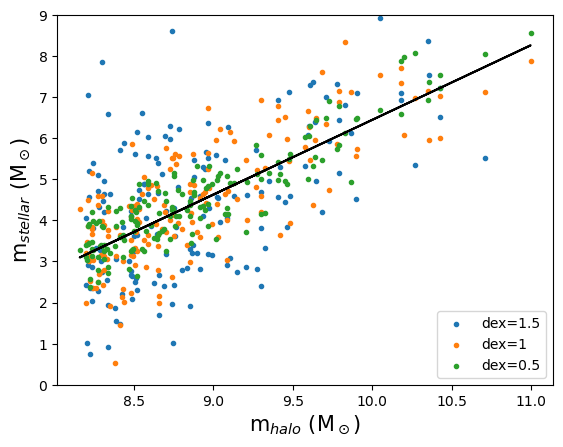

In [186]:
plt.scatter(halo_mass, samp3, marker=".", label="dex=1.5")
plt.scatter(halo_mass, samp2, marker=".", label="dex=1")
plt.scatter(halo_mass, samp1, marker=".", label="dex=0.5")
plt.plot(halo_mass, stellar_mass, color="black")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.ylim(0,9)
plt.legend()
plt.show()

In [187]:
samp1 = test_convlog(stellar_mass, 0.5, 10)[0,:]

samp2 = test_convlog(stellar_mass, 1, 10)[0,:]

samp3 = test_convlog(stellar_mass, 1.5, 10)[0,:]

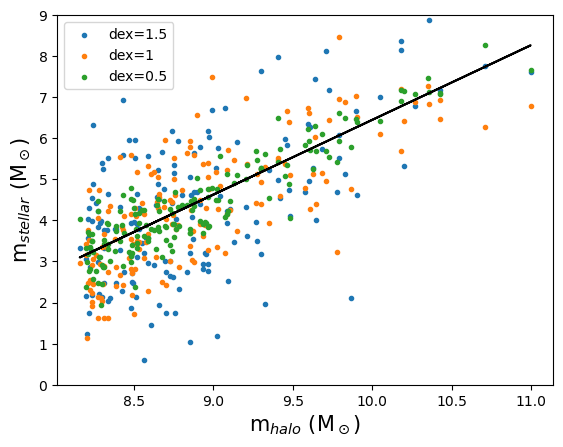

In [188]:
plt.scatter(halo_mass, samp3, marker=".", label="dex=1.5")
plt.scatter(halo_mass, samp2, marker=".", label="dex=1")
plt.scatter(halo_mass, samp1, marker=".", label="dex=0.5")
plt.plot(halo_mass, stellar_mass, color="black")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend()
plt.ylim(0,9)
plt.show()

### now moving onto the differnt ways we can normalize the sampling

In [189]:
Mh = prep_data(("../../data/12_4_0/acc_surv_mass.npy"), convert=False, includenan=False)
Ms = prep_data(("../../data/12_4_0/acc_surv_mass.npy"), includenan=False)

halo_mass = Mh[0]
stellar_mass = Ms[0]

In [190]:
def lgMs_D22_test(lgMv, dex):
    """    
    returns the stellar mass [M_sun] plus a random sample of a lognormal distribution defined by dex
    """

    aGK = 0.14*dex**2 + 0.14*dex+ 1.79
    log_e = -1.5
    lgMs = log_e + 12.5 + aGK*lgMv - aGK*12.5

    return lgMs

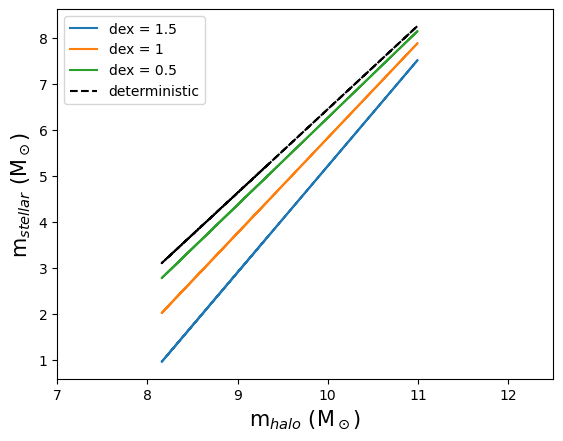

In [191]:
plt.plot(halo_mass, lgMs_D22_test(halo_mass,1.5), label="dex = 1.5")
plt.plot(halo_mass, lgMs_D22_test(halo_mass,1), label="dex = 1")
plt.plot(halo_mass, lgMs_D22_test(halo_mass,0.5) , label="dex = 0.5")

plt.plot(halo_mass, stellar_mass, color="black", label="deterministic", ls="--")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend()
plt.xlim(7,12.5)
#plt.savefig("../figures/scaling_SHMR.pdf")
plt.show()

In [192]:
def lgMs_D22_test(lgMv, dex, N_samples, norm=False):
    """    
    returns the stellar mass [M_sun] plus a random sample of a lognormal distribution defined by dex
    """
    log_e = -1.5
    a = 1.82
    lgMs = log_e + 12.5 + a*lgMv - a*12.5

    sample = np.random.lognormal(lgMs, dex, size=(N_samples, lgMs.shape[0]))
    lgMs_mat = np.log10(sample)/np.log10(np.exp(1))

    norm = (dex**2)/4.605
    return lgMs_mat - norm


In [193]:
hmm = lgMs_D22_test(halo_mass, 1.5, N_samples=100)

hmm.shape

(100, 168)

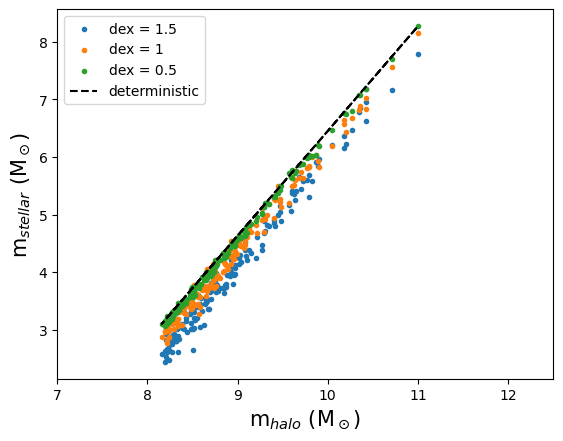

In [194]:
plt.scatter(halo_mass,  np.average(lgMs_D22_test(halo_mass,1.5, N_samples=100), axis=0), marker=".", label="dex = 1.5")
plt.scatter(halo_mass,  np.average(lgMs_D22_test(halo_mass,1, N_samples=100), axis=0) , marker=".", label="dex = 1")
plt.scatter(halo_mass, np.average(lgMs_D22_test(halo_mass,0.5, N_samples=100), axis=0) , marker=".", label="dex = 0.5")

plt.plot(halo_mass, stellar_mass, color="black", label="deterministic", ls="--")
plt.ylabel("m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.xlabel("m$_{halo}$ (M$_\odot$)", fontsize=15)
plt.legend()
plt.xlim(7,12.5)
#plt.savefig("../figures/scaling_SHMR.pdf")
plt.show()

### now checking the mass conservation!

In [195]:
scatter_pix = 15
scatter_range = np.round(np.linspace(0.0,1.5,scatter_pix), 3)

beta = np.load("../../data/beta_norm.npy")

unscaled = np.load("../../data/nonorm.npy")

slope = np.load("../../data/alpha_norm.npy")

det = 11.93399835074119

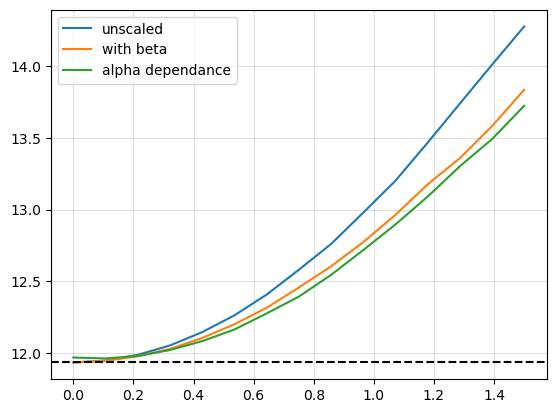

In [196]:
plt.plot(scatter_range, unscaled, label="unscaled")
plt.plot(scatter_range, beta, label="with beta")
plt.plot(scatter_range, slope, label="alpha dependance")
plt.axhline(det, ls="--", color="black")
plt.grid(alpha=0.4)
plt.legend()
plt.show()